In [70]:
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity

#app = AiZynthApp("config_local.yml")

In [77]:
template_rxn = '[C:1](=[O:2])([cH3:3])[N:5][CH3:4]>>O[C:1](=[O:2])[cH3:3].[CH3:4][N:5]'
amidation = '[#6:1](=[#8:2])-[#8;H1].[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):3]>>[#6:1](=[#8:2])-[#7X3:3]'
steglich_esterification = '[OH]-[C;H0;D3;+0:1]=[O;D1;H0:3].[CX4;+0:7]-[OH;D1;+0:9]>>[CX4:7]-[O;H0;D2;+0:9]-[C;H0;D3;+0:1]=[O;D1;H0:3]'

# reconstruct template_rxn SMARTS around '>>'
parts = template_rxn.split('>>')
product, reactants = parts
template_rxn = f"{reactants}>>{product}"

# how to calculate similarity between these?
template_rxn = AllChem.ReactionFromSmarts(template_rxn)
amidation = AllChem.ReactionFromSmarts(amidation)
se = AllChem.ReactionFromSmarts(steglich_esterification)
# calculate tanimoto similarity
template_rxn_fp = AllChem.CreateDifferenceFingerprintForReaction(template_rxn)
amidation_fp = AllChem.CreateDifferenceFingerprintForReaction(amidation)
se_fp = AllChem.CreateDifferenceFingerprintForReaction(se)

# Calculate Tanimoto similarity
similarity = TanimotoSimilarity(template_rxn_fp, amidation_fp)
print(similarity)

similarity = TanimotoSimilarity(template_rxn_fp, se_fp)
print(similarity)

0.07142857142857142
0.11764705882352941


In [78]:
# For structural fingerprints (more focus on overall structure)
template_rxn_fp = AllChem.CreateStructuralFingerprintForReaction(template_rxn)
amidation_fp = AllChem.CreateStructuralFingerprintForReaction(amidation)
se_fp = AllChem.CreateStructuralFingerprintForReaction(se)

# Calculate Tanimoto similarity
similarity = TanimotoSimilarity(template_rxn_fp, amidation_fp)
print(similarity)

similarity = TanimotoSimilarity(template_rxn_fp, se_fp)
print(similarity)

0.4117647058823529
0.44285714285714284


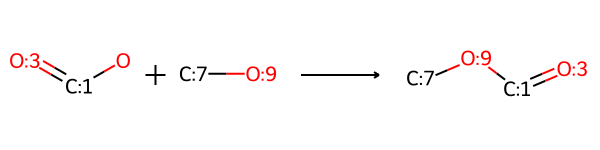

In [79]:
se

In [112]:
import numpy as np
from rdkit.Chem import MACCSkeys, Mol
from rdkit import Chem
import numpy.typing as npt
from typing import Any
from scipy.spatial.distance import jaccard


def morgan_fp(mol: Mol) -> npt.NDArray[Any]:
    fp1 = AllChem.GetMorganFingerprintAsBitVect(
        mol, useChirality=True, radius=2, nBits=1024
    )
    vec1 = np.array(fp1)
    return vec1


def maccs_fp(mol: Chem.rdchem.Mol) -> npt.NDArray[Any]:
    return np.array(MACCSkeys.GenMACCSKeys(mol))


def get_fp(rxn: str, fp: str = "MACCS", concatenate: bool = True) -> npt.NDArray[Any]:
    reactant_str, product_str = rxn.split(">>")
    reactants = reactant_str.split(".")
    products = product_str.split(".")
    print(reactants, products)
    reactant_mols = [Chem.MolFromSmarts(reactant) for reactant in reactants]
    product_mols = [Chem.MolFromSmarts(product) for product in products]

    for mol in reactant_mols:
        mol.UpdatePropertyCache(strict=False)
        Chem.GetSSSR(mol)

    for mol in product_mols:
        mol.UpdatePropertyCache(strict=False)
        Chem.GetSSSR(mol)

    print(reactant_mols, product_mols)

    if fp.lower() == "maccs":
        reactant_fp = np.sum(np.array([maccs_fp(mol) for mol in reactant_mols]), axis=0)
        product_fp = np.sum(np.array([maccs_fp(mol) for mol in product_mols]), axis=0)
    elif fp.lower() == "morgan":
        reactant_fp = np.sum(
            np.array([morgan_fp(mol) for mol in reactant_mols]), axis=0
        )
        product_fp = np.sum(np.array([morgan_fp(mol) for mol in product_mols]), axis=0)
    else:
        raise KeyError(
            f"Fingerprint {fp} is not yet supported. Choose between MACCS and Morgan"
        )

    if concatenate:
        rxn_fp = np.concatenate((reactant_fp, product_fp))
    else:
        rxn_fp = np.sum((reactant_fp, product_fp), axis=0)

    return rxn_fp


template_rxn = '[C:1](=[O:2])([cH3:3])[N:5][CH3:4]>>O[C:1](=[O:2])[cH3:3].[CH3:4][N:5]'
amidation = '[#6:1](=[#8:2])-[#8;H1].[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):3]>>[#6:1](=[#8:2])-[#7X3:3]'

# reconstruct template_rxn SMARTS around '>>'
parts = template_rxn.split('>>')
product, reactants = parts
template_rxn = f"{reactants}>>{product}"

tr_fp = get_fp(template_rxn, "maccs", concatenate=False)
amid_fp = get_fp(amidation, "maccs", concatenate=False)
se_fp = get_fp(steglich_esterification, "maccs", concatenate=False)
jaccard_similarity = 1 - jaccard(tr_fp, amid_fp)
jaccard_similarity_se = 1 - jaccard(tr_fp, se_fp)

print(jaccard_similarity)
print(jaccard_similarity_se)

['O[C:1](=[O:2])[cH3:3]', '[CH3:4][N:5]'] ['[C:1](=[O:2])([cH3:3])[N:5][CH3:4]']
[<rdkit.Chem.rdchem.Mol object at 0x34a5c1ee0>, <rdkit.Chem.rdchem.Mol object at 0x34a5c2810>] [<rdkit.Chem.rdchem.Mol object at 0x34a5c0ba0>]
['[#6:1](=[#8:2])-[#8;H1]', '[$([N+0&H1,N+0&H2]);!$(NC=*);!$(NS);!$(N=*);!$(N-O);!$(N-o):3]'] ['[#6:1](=[#8:2])-[#7X3:3]']
[<rdkit.Chem.rdchem.Mol object at 0x34a5c1ee0>, <rdkit.Chem.rdchem.Mol object at 0x34a5c2810>] [<rdkit.Chem.rdchem.Mol object at 0x34a5c26c0>]
['[OH]-[C;H0;D3;+0:1]=[O;D1;H0:3]', '[CX4;+0:7]-[OH;D1;+0:9]'] ['[CX4:7]-[O;H0;D2;+0:9]-[C;H0;D3;+0:1]=[O;D1;H0:3]']
[<rdkit.Chem.rdchem.Mol object at 0x34a5c2810>, <rdkit.Chem.rdchem.Mol object at 0x34a5c0ba0>] [<rdkit.Chem.rdchem.Mol object at 0x34a5c0580>]
0.5
0.4375


In [ ]:
# compute similarity to all smirks


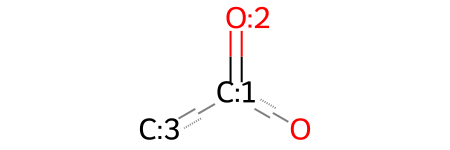

In [94]:
mol = Chem.MolFromSmarts('O[C:1](=[O:2])[cH3:3]')
mol

In [61]:
from aizynthfinder.aizynthfinder import AiZynthFinder

finder = AiZynthFinder(configfile="config_local.yml")
finder.stock.select("zinc")
finder.expansion_policy.select("uspto")
finder.filter_policy.select("uspto")

Loading template-based expansion policy model from uspto_model.onnx to uspto
Loading templates from uspto_templates.csv.gz to uspto
Loading filter policy model from uspto_filter_model.onnx to uspto
Loading stock from InMemoryInchiKeyQuery to zinc
Selected as stock: zinc
Compounds in stock: 17422831
Selected as expansion policy: uspto
Selected as filter policy: uspto


In [63]:
not finder.extract_statistics()

True

In [ ]:
finder.target_smiles = "O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1"
finder.tree_search()

In [ ]:
finder.build_routes()
stats = finder.extract_statistics()

In [ ]:
stats

In [ ]:
for route in finder.routes:
    print(route)
    tree = route['reaction_tree']
    print(tree.is_branched())
    print(tree.reactions())
    for reaction in tree.reactions():
        print(reaction)
        smiles_based = reaction.to_smiles_based_retroreaction()
        print(smiles_based.to_dict())

In [ ]:
from aizynthfinder.aizynthfinder import AiZynthExpander

expander = AiZynthExpander(configfile="config_local.yml")
expander.expansion_policy.select("full")
expander.filter_policy.select("uspto")
reactions = expander.do_expansion("O=C(NC1CC(C(F)(F)F)C1)c1cc2ccsc2[nH]1")

In [ ]:
import pandas as pd

metadata = []
for reaction_tuple in reactions:
    for reaction in reaction_tuple:
        metadata.append(reaction.metadata)
df = pd.DataFrame(metadata)

In [ ]:
df